In [1]:
# 라이브러리 및 모듈 import
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
import os
import torch
from torch.utils.data import DataLoader, Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
import pandas as pd
from tqdm import tqdm
from glob import glob
from PIL import Image, ImageDraw
from utils import nms

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
class TestDataset(Dataset):
    def __init__(self, img_list, transform):
        super().__init__()
        self.img_list = img_list
        self.transform = transform

    def __getitem__(self, idx):
        file_name = self.img_list[idx]
        img = Image.open(file_name).convert('RGB')
        #img_size = torch.tensor(np.array(img).shape[:-1]).unsqueeze(0)
        img = np.array(img).astype(np.float32) / 255.0
        img = self.transform(image=np.array(img))['image']
        return file_name, img
    
    def __len__(self):
        return len(self.img_list)


In [3]:
# Albumentation을 이용, augmentation 선언
def get_train_transform():
    return A.Compose([
        A.Resize(512, 512),
        A.Flip(p=0.5),
        ToTensorV2(p=1.0)
    ])


def get_valid_transform():
    return A.Compose([
        A.Resize(512, 512),
        ToTensorV2(p=1.0)
    ])

In [4]:
img_list = glob('./dataset/test/*.png')
test_dataset = TestDataset(img_list, get_valid_transform())

In [5]:
from effdet import DetBenchPredict
import gc

# Effdet config를 통해 모델 불러오기 + ckpt load
def load_net(checkpoint_path, device):
    config = get_efficientdet_config('tf_efficientdet_d0')
    config.num_classes = 34
    config.image_size = (512,512)
    
    config.soft_nms = False
    config.max_det_per_image = 25
    
    net = EfficientDet(config, pretrained_backbone=False)
    net.class_net = HeadNet(config, num_outputs=config.num_classes)
    
    checkpoint = torch.load(checkpoint_path, map_location='cpu')

    net = DetBenchPredict(net)
    net.load_state_dict(checkpoint)
    net.eval()

    return net.to(device)

In [6]:
def denormalize_box(box):
    x1 = list(box)[0] * (1920/512)
    y1 = list(box)[1] * (1080/512)
    x2 = list(box)[2] * (1920/512)
    y2 = list(box)[3] * (1080/512)
    return x1, y1, x2, y2

In [87]:
checkpoint_path = f'./ckp/epoch_25.pth'

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = load_net(checkpoint_path, device)

test_data_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
)

results_csv = pd.read_csv('./dataset/sample_submission.csv')

for file_names, image in tqdm(test_data_loader):
    image = image.to(device).float()
    with torch.no_grad():
        output = model(image)
    outputs = []
    for out in output:
        outputs.append({'boxes': out.detach().cpu().numpy()[:,:4], 
                        'scores': out.detach().cpu().numpy()[:,4], 
                        'labels': out.detach().cpu().numpy()[:,-1]})
    
    for file_name, output in zip(file_names, outputs):
        file_name = file_name.split('\\')[1]
        boxes = []
        scores = []
        labels = []
        for box, score, label  in zip(output['boxes'],output['scores'],output['labels']):
            x1, y1, x2, y2 = denormalize_box(box)
            score = score
            label = label
            boxes.append([x1, y1, x2, y2])
            scores.append(score)
            labels.append(label)
        picked_boxes, picked_score, picked_labels = nms(boxes, scores, labels, 0.5)

        for box, score, label in zip(picked_boxes, picked_score, picked_labels):
            if score < 0.5:
                break
            x1, y1, x2, y2 = box
            score = score
            label = label
            results_csv.loc[len(results_csv.index)] = pd.Series({"file_name": file_name,
            "class_id": int(label-1),
            "confidence": score,
            "point1_x": int(x1), "point1_y": int(y2),
            "point2_x": int(x2), "point2_y": int(y2),
            "point3_x": int(x2), "point3_y": int(y1),
            "point4_x": int(x1), "point4_y": int(y1)})
            # results_csv.loc[len(results_csv.index)] = pd.Series({"file_name": file_name,
            # "class_id": label,
            # "confidence": score,
            # "point1_x": int(x1), "point1_y": int(y1),
            # "point2_x": int(x2), "point2_y": int(y1),
            # "point3_x": int(x2), "point3_y": int(y2),
            # "point4_x": int(x1), "point4_y": int(y2)})

100%|██████████| 850/850 [04:29<00:00,  3.16it/s]


In [88]:
np.unique(results_csv.class_id)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
      dtype=object)

In [11]:
results_csv

,file_name,class_id,confidence,point1_x,point1_y,point2_x,point2_y,point3_x,point3_y,point4_x,point4_y
0,064442001.png,16,0.75772,1134,497,1428,497,1428,192,1134,192
1,064507368.png,16,0.766491,488,427,752,427,752,126,488,126
2,065147868.png,16,0.798926,724,503,1014,503,1014,192,724,192
3,065203472.png,17,0.784096,754,603,1072,603,1072,249,754,249
4,065223169.png,30,0.85599,738,457,1017,457,1017,167,738,167
...,...,...,...,...,...,...,...,...,...,...,...
2836,183730886.png,1,0.849261,1310,886,1624,886,1624,588,1310,588
2837,183744509.png,1,0.829135,900,998,1211,998,1211,673,900,673
2838,183911746.png,27,0.923543,751,559,1005,559,1005,271,751,271
2839,183928410.png,27,0.500938,681,332,920,332,920,64,681,64


[1134 192 1428 497] [0.75771993] [16]


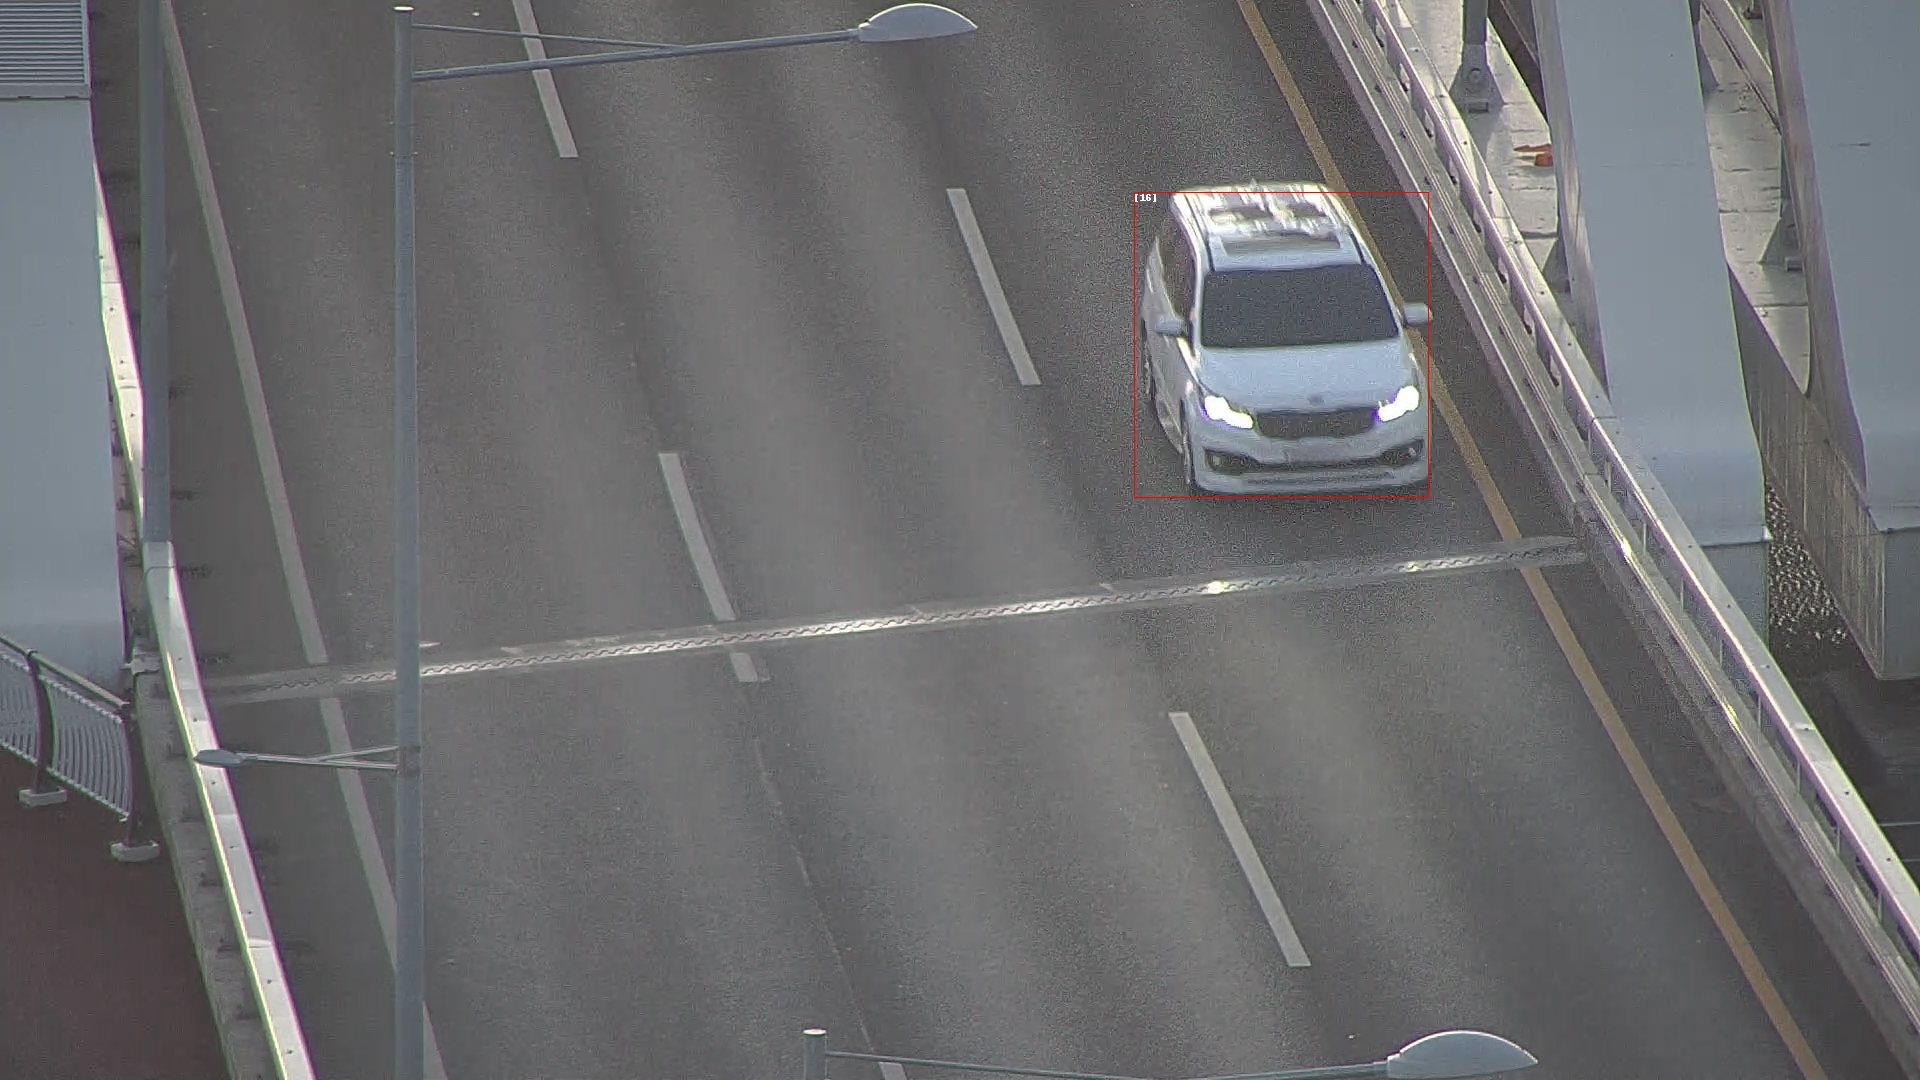

In [85]:
from PIL import Image, ImageDraw

index = 0
df_index = results_csv[results_csv['file_name'] == results_csv.iloc[index]['file_name']]
file_name = './dataset/test/'+ results_csv.iloc[index]['file_name']
box = df_index[['point1_x' ,'point3_y', 'point2_x', 'point1_y']].values
score = df_index[['confidence']].values
label = df_index[['class_id']].values
img = Image.open(file_name)
draw = ImageDraw.Draw(img, "RGBA")

for i,j,k in zip(box, score, label):
    print(i,j,k)
    draw.rectangle(tuple(i), outline='red', width=1)
    draw.text((i[0],i[1]),text=str(k))
img

In [86]:
results_csv.to_csv('./result.csv', index = False, encoding = 'utf-8')

In [3]:
import pandas as pd
results_csv = pd.read_csv('./result.csv')

In [7]:
results_csv['class_id'] = results_csv['class_id']-1

In [5]:
np.unique(results_csv['class_id'],return_counts=True)

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32.]),
 array([ 37, 222,  92, 109,  14, 229, 109, 264, 199,  79, 211,  45, 286,
         59,  75,  21, 110,  81,  65,  82, 102, 198, 262, 240,  11,  22,
        209,  70, 320, 126, 244, 144, 209], dtype=int64))

In [ ]:
index = 3016
file_name = './dataset/test/'+ results_csv.file_name[index]
img = Image.open(file_name)
x1, y1, x2, y2 = results_csv.point1_x[index] ,results_csv.point3_y[index], results_csv.point2_x[index], results_csv.point2_y[index]

draw = ImageDraw.Draw(img, "RGBA")
draw.rectangle((x1,y1,x2,y2), outline='red', width=1)
img.show()